In [15]:
# Create plots and tables for the logs of the different runs of the dbs
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import extractor
import ast


# First we look at the different runs that both MariaDB and PostgreSQL have done


| Test Case | `max_connections` | `buffer_pool_size` | `log_buffer_size` | `virtual_users` | `warehouses` | Test Nº |
| --------- | ----------------- | ------------------ | ----------------- | --------------- | ------------ | ------- |
| Small     | 100               | 256M               | 8M                | 5               | 5            | 1       |
| Medium    | 200               | 512M               | 16M               | 10              | 10           | 2       |
| Large     | 500               | 1G                 | 32M               | 20              | 20           | 3       |
| Max CPU   | 500               | 2G                 | 64M               | 50              | 20           | 4       |
| I/O Test  | 200               | 256M               | 8M                | 20              | 5            | 5       |
| Memory    | 200               | 2G                 | 64M               | 10              | 10           | 6       |
| Latency   | 100               | 128M               | 8M                | 5               | 20           | 7       |
| Stress    | 1000              | 4G                 | 128M              | 100             | 50           | 8       |

For each of these scenatios we also ran with the use all warehouses option to both false and true. So that we could see the impact of using all warehouses on the performance of the database.

Aditionally both group members ran all the same scenarios with the same parameters.

Their machine specifications were:
| Machine | CPU | RAM | Disk Type | OS Version | 
| ------- | --- | --- | --------- | ---------- |
| José Pedreira | Apple M4 Pro, 12 cores (8 performance cores + 4 efficiency cores) | 24 GB DDR4 | SSD       | macOS 15.5 (24F74) with Ubuntu 20.04 LTS running on a VM  |
| Member 2 | 8 cores | 32 GB | SSD       |


# Let's look at the results of the runs for MariaDB first with the warehouses set to false

In [2]:
extractor.extract_all_logs_to_csv("hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/")

✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu100_wh50_mc1000_bp4G_lb128_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu10_wh10_mc200_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu10_wh10_mc200_bp512M_lb16_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu20_wh20_mc500_bp1G_lb32_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu20_wh5_mc200_bp256M_lb8_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu50_wh20_mc500_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu5_wh20_mc100_bp128M_lb8_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu5_wh5_mc100_bp256M_lb8_dict.txt
✅ Extracted 32 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run1.log (Test 8: Stress)
✅ Extracted 33 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run2.log (Test 8: Stress)
✅ Extracted 32 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run3.log (Test 8: 

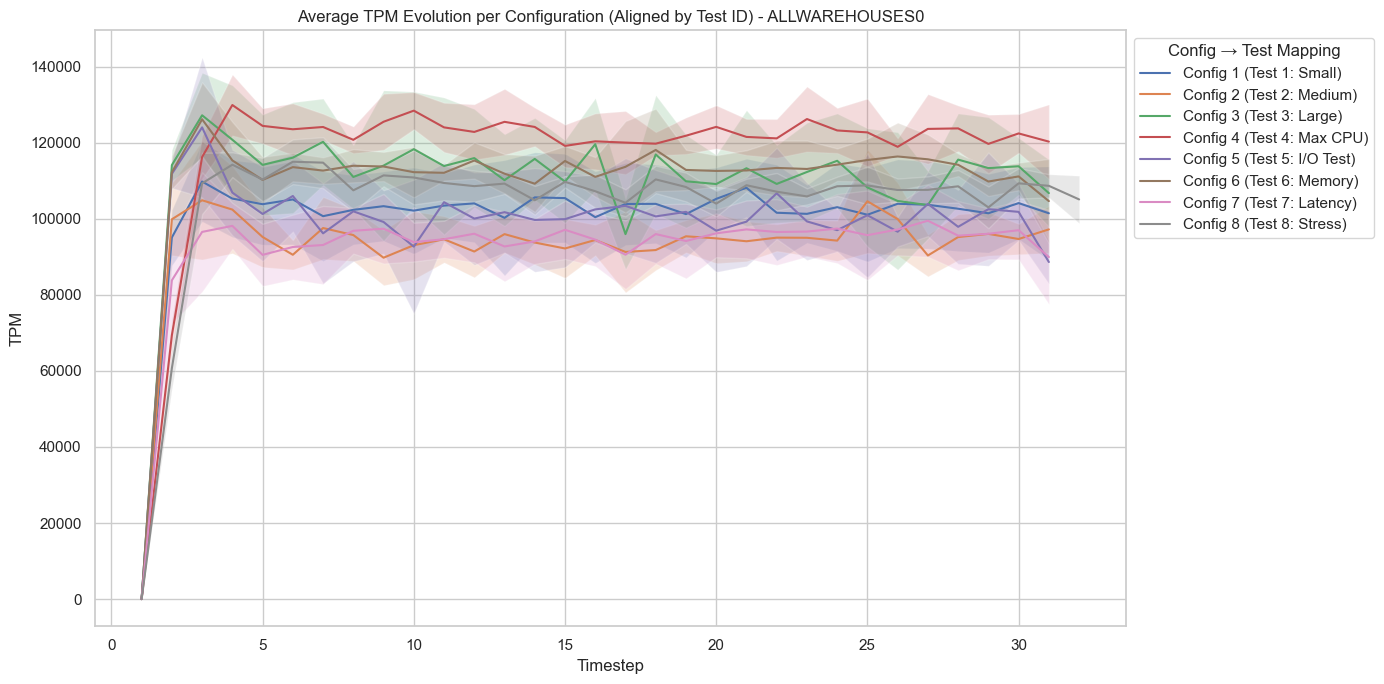

In [3]:
df = pd.read_csv('hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]

df['test_id'] = df['test_id'].astype(int)
df['config_num'] = df['test_id'].astype(str)

grouped = df.groupby('test_id')

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for test_id, group in grouped:
    tpm_lists = group['tpm_values'].tolist()
    min_len = min(len(run) for run in tpm_lists)
    tpm_matrix = np.array([run[:min_len] for run in tpm_lists])

    mean_tpm = tpm_matrix.mean(axis=0)
    std_tpm = tpm_matrix.std(axis=0)
    x = np.arange(1, min_len + 1)

    first_row = group.iloc[0]
    config_label = str(test_id)
    test_label = f"Test {test_id}: {first_row['test_name']}"

    label = f"Config {config_label} ({test_label})"
    plt.plot(x, mean_tpm, label=label)
    plt.fill_between(x, mean_tpm - std_tpm, mean_tpm + std_tpm, alpha=0.2)

plt.title("Average TPM Evolution per Configuration (Aligned by Test ID) - ALLWAREHOUSES0")
plt.xlabel("Timestep")
plt.ylabel("TPM")
plt.legend(title="Config → Test Mapping", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

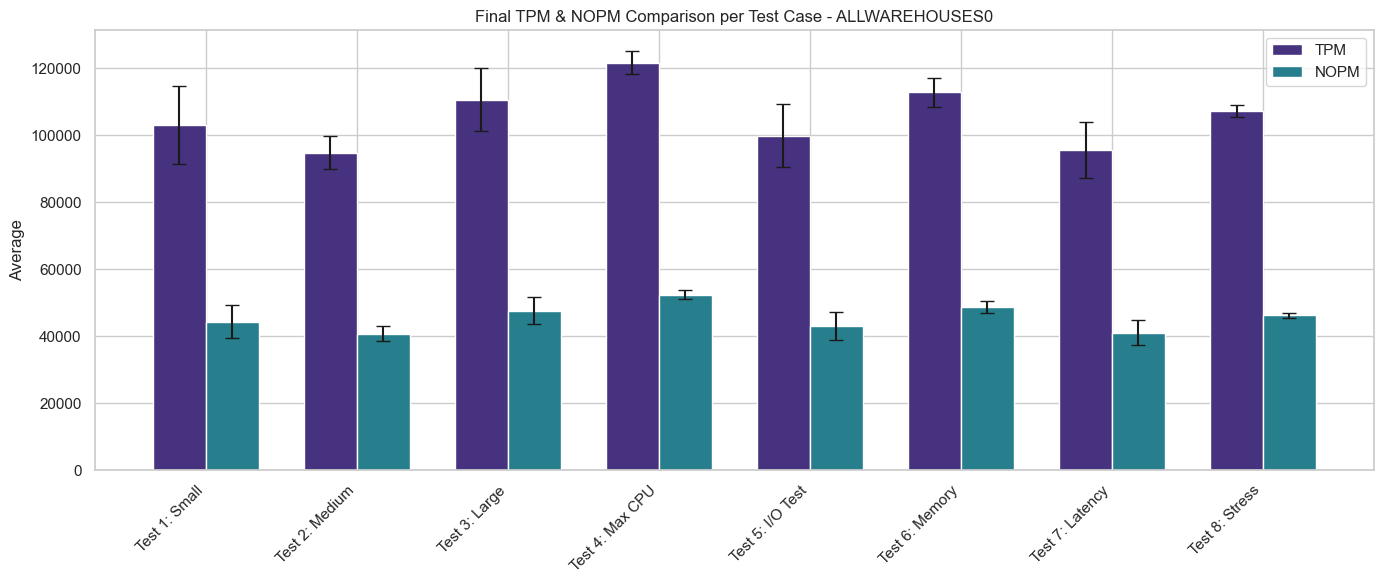

In [4]:
df = pd.read_csv('hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)

summary_stats = df.groupby(['test_id', 'test_name']).agg(
    avg_final_tpm=('final_tpm', 'mean'),
    std_final_tpm=('final_tpm', 'std'),
    avg_final_nopm=('final_nopm', 'mean'),
    std_final_nopm=('final_nopm', 'std')
).reset_index()

summary_stats = summary_stats.sort_values('test_id')

x_labels = [f"Test {tid}: {name}" for tid, name in zip(summary_stats['test_id'], summary_stats['test_name'])]
x = np.arange(len(summary_stats)) 
width = 0.35 

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

plt.bar(
    x - width/2,
    summary_stats['avg_final_tpm'],
    width=width,
    label='TPM',
    yerr=summary_stats['std_final_tpm'],
    capsize=5,
    color=sns.color_palette('viridis')[0]
)

plt.bar(
    x + width/2,
    summary_stats['avg_final_nopm'],
    width=width,
    label='NOPM',
    yerr=summary_stats['std_final_nopm'],
    capsize=5,
    color=sns.color_palette('viridis')[2]
)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("Average")
plt.title("Final TPM & NOPM Comparison per Test Case - ALLWAREHOUSES0")
plt.legend()
plt.tight_layout()
plt.show()

# Now with the warehouses set to true

In [5]:
extractor.extract_all_logs_to_csv("hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/")

✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu100_wh50_mc1000_bp4G_lb128_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu10_wh10_mc200_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu10_wh10_mc200_bp512M_lb16_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu20_wh20_mc500_bp1G_lb32_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu20_wh5_mc200_bp256M_lb8_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu50_wh20_mc500_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu5_wh20_mc100_bp128M_lb8_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu5_wh5_mc100_bp256M_lb8_dict.txt
✅ Extracted 33 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run1.log (Test 8: Stress)
✅ Extracted 33 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run2.log (Test 8: Stress)
✅ Extracted 33 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run3.log (Test 8: 

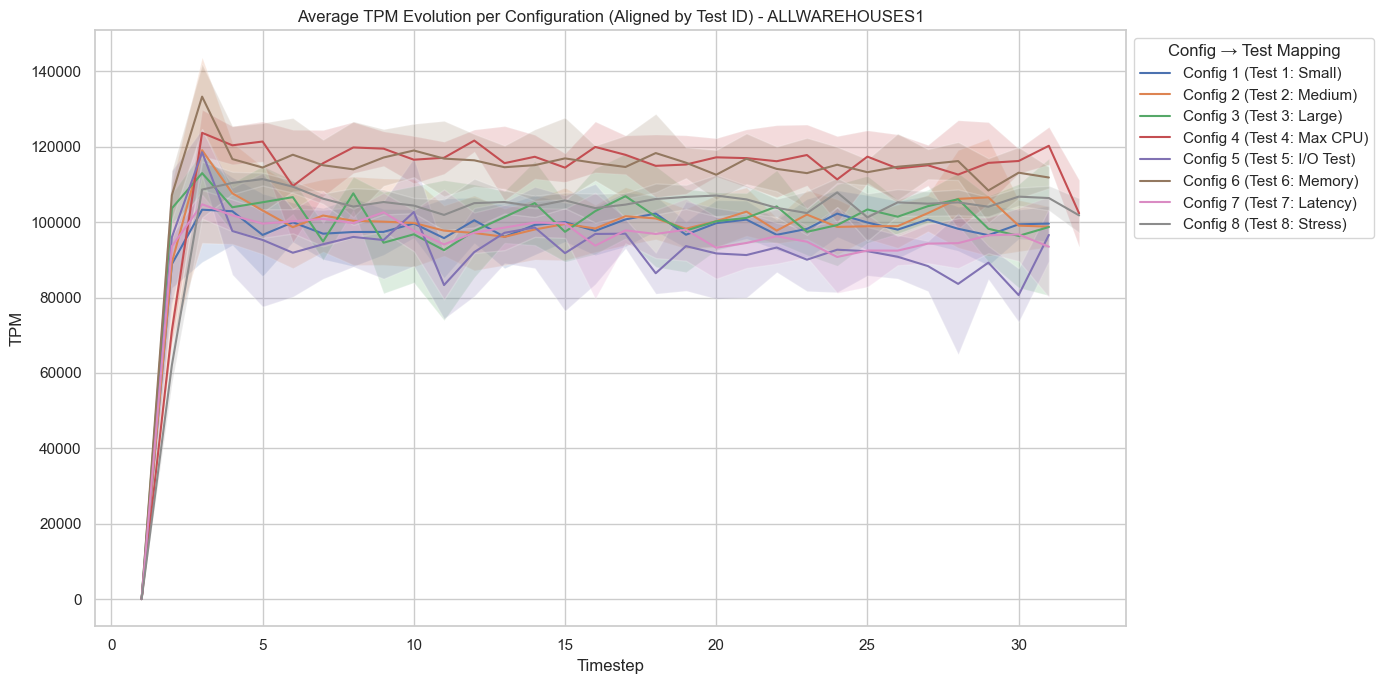

In [6]:
df = pd.read_csv('hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]

df['test_id'] = df['test_id'].astype(int)
df['config_num'] = df['test_id'].astype(str)

grouped = df.groupby('test_id')

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for test_id, group in grouped:
    tpm_lists = group['tpm_values'].tolist()
    min_len = min(len(run) for run in tpm_lists)
    tpm_matrix = np.array([run[:min_len] for run in tpm_lists])

    mean_tpm = tpm_matrix.mean(axis=0)
    std_tpm = tpm_matrix.std(axis=0)
    x = np.arange(1, min_len + 1)

    first_row = group.iloc[0]
    config_label = str(test_id)
    test_label = f"Test {test_id}: {first_row['test_name']}"

    label = f"Config {config_label} ({test_label})"
    plt.plot(x, mean_tpm, label=label)
    plt.fill_between(x, mean_tpm - std_tpm, mean_tpm + std_tpm, alpha=0.2)

plt.title("Average TPM Evolution per Configuration (Aligned by Test ID) - ALLWAREHOUSES1")
plt.xlabel("Timestep")
plt.ylabel("TPM")
plt.legend(title="Config → Test Mapping", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

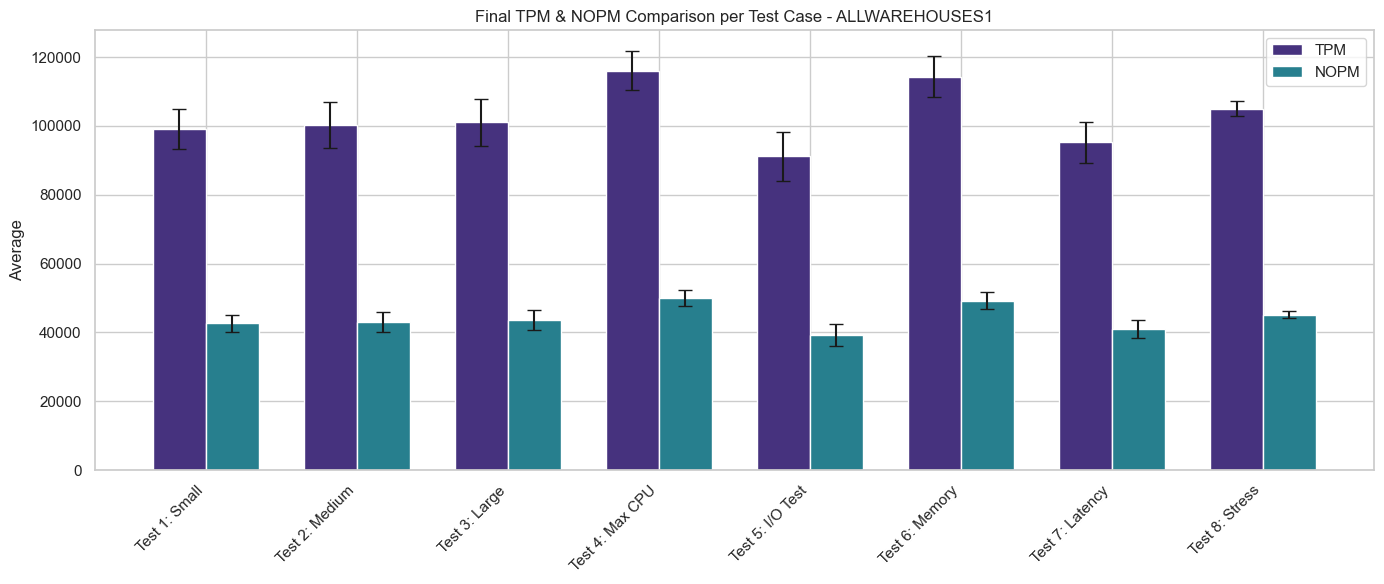

In [7]:
df = pd.read_csv('hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)

summary_stats = df.groupby(['test_id', 'test_name']).agg(
    avg_final_tpm=('final_tpm', 'mean'),
    std_final_tpm=('final_tpm', 'std'),
    avg_final_nopm=('final_nopm', 'mean'),
    std_final_nopm=('final_nopm', 'std')
).reset_index()

summary_stats = summary_stats.sort_values('test_id')

x_labels = [f"Test {tid}: {name}" for tid, name in zip(summary_stats['test_id'], summary_stats['test_name'])]
x = np.arange(len(summary_stats)) 
width = 0.35 

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

plt.bar(
    x - width/2,
    summary_stats['avg_final_tpm'],
    width=width,
    label='TPM',
    yerr=summary_stats['std_final_tpm'],
    capsize=5,
    color=sns.color_palette('viridis')[0]
)

plt.bar(
    x + width/2,
    summary_stats['avg_final_nopm'],
    width=width,
    label='NOPM',
    yerr=summary_stats['std_final_nopm'],
    capsize=5,
    color=sns.color_palette('viridis')[2]
)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("Average")
plt.title("Final TPM & NOPM Comparison per Test Case - ALLWAREHOUSES1")
plt.legend()
plt.tight_layout()
plt.show()

# Let's to see if the warehouses setting has an impact on the performance of the database.

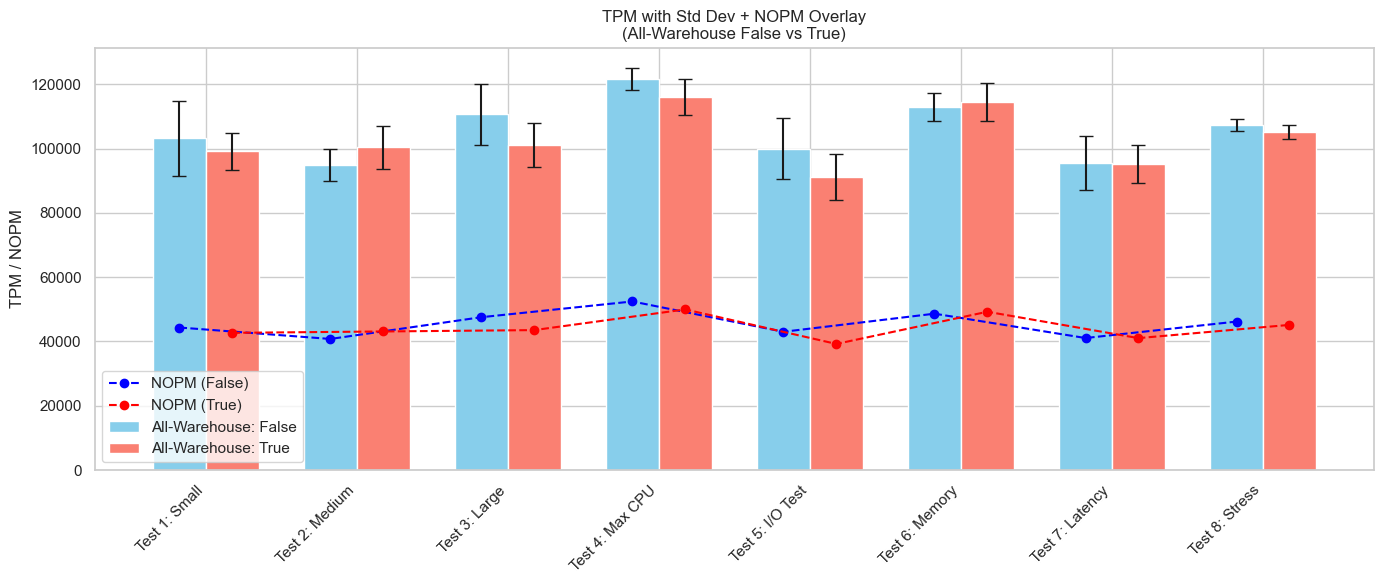

In [12]:
df0 = pd.read_csv("hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/summary.csv")
df1 = pd.read_csv("hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/summary.csv")

df0['allwarehouse'] = False
df1['allwarehouse'] = True

df = pd.concat([df0, df1], ignore_index=True)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)
df['allwarehouse'] = df['allwarehouse'].astype(bool)

grouped = df.groupby(['test_id', 'test_name', 'allwarehouse']).agg(
    avg_tpm=('final_tpm', 'mean'),
    std_tpm=('final_tpm', 'std'),
    avg_nopm=('final_nopm', 'mean'),
    std_nopm=('final_nopm', 'std')
).reset_index()

grouped = grouped.sort_values('test_id')

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

x_labels = [f"Test {tid}: {name}" for tid, name in grouped.groupby('test_id').first()['test_name'].items()]
x = np.arange(len(x_labels))
bar_width = 0.35

bar_false = grouped[grouped['allwarehouse'] == False]
bar_true = grouped[grouped['allwarehouse'] == True]

bars1 = plt.bar(x - bar_width/2, bar_false['avg_tpm'], yerr=bar_false['std_tpm'], capsize=5,
                width=bar_width, label='All-Warehouse: False', color='skyblue')
bars2 = plt.bar(x + bar_width/2, bar_true['avg_tpm'], yerr=bar_true['std_tpm'], capsize=5,
                width=bar_width, label='All-Warehouse: True', color='salmon')

plt.plot(x - bar_width/2, bar_false['avg_nopm'], marker='o', linestyle='--', color='blue', label='NOPM (False)')
plt.plot(x + bar_width/2, bar_true['avg_nopm'], marker='o', linestyle='--', color='red', label='NOPM (True)')

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("TPM / NOPM")
plt.title("TPM with Std Dev + NOPM Overlay\n(All-Warehouse False vs True)")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
df0 = pd.read_csv("hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/summary.csv")
df1 = pd.read_csv("hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/summary.csv")

df0['allwarehouse'] = False
df1['allwarehouse'] = True

df = pd.concat([df0, df1], ignore_index=True)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)
df['allwarehouse'] = df['allwarehouse'].astype(bool)

agg_df = df.groupby(['test_id', 'test_name', 'allwarehouse']).agg(
    avg_tpm=('final_tpm', 'mean'),
    std_tpm=('final_tpm', 'std'),
    min_tpm=('final_tpm', 'min'),
    max_tpm=('final_tpm', 'max'),
    avg_nopm=('final_nopm', 'mean'),
    std_nopm=('final_nopm', 'std'),
    min_nopm=('final_nopm', 'min'),
    max_nopm=('final_nopm', 'max'),
    runs=('filename', 'count')
).reset_index()

from IPython.display import display
display(agg_df)
agg_df.to_csv("aggregated_results.csv", index=False)
print("Exported as aggregated_results.csv")

,test_id,test_name,allwarehouse,avg_tpm,std_tpm,min_tpm,max_tpm,avg_nopm,std_nopm,min_nopm,max_nopm,runs
0,1,Small,False,103168.6,11692.339984,91181,120187,44345.6,4938.537415,39260,51525,5
1,1,Small,True,99166.8,5820.684084,89037,103089,42688.6,2524.298576,38287,44320,5
2,2,Medium,False,94839.8,4996.440853,89365,101887,40787.8,2176.199830,38435,43851,5
3,2,Medium,True,100341.4,6638.772424,94660,109554,43116.8,2877.303981,40545,47108,5
4,3,Large,False,110600.4,9358.924447,99266,124666,47555.4,4001.246656,42694,53554,5
5,3,Large,True,101104.8,6849.694022,90643,108927,43539.4,2961.477131,38959,46829,5
6,4,Max CPU,False,121708.2,3361.480953,117845,125544,52446.6,1458.146872,50713,54138,5
7,4,Max CPU,True,115993.6,5678.209427,106196,120932,49971.0,2428.002986,45737,51913,5
8,5,I/O Test,False,99867.8,9480.759474,89498,114030,43017.8,4139.339645,38482,49215,5
9,5,I/O Test,True,91206.2,7081.485098,83041,101281,39237.6,3090.050210,35615,43516,5


Exported as aggregated_results.csv


In [24]:
# Best configuration by average TPM
best_tpm_row = agg_df.loc[agg_df['avg_tpm'].idxmax()]
print("Best TPM configuration:")
display(best_tpm_row)

# Top 3 configurations
top3 = agg_df.sort_values('avg_tpm', ascending=False).head(3)
print("Top 3 Configurations by Avg TPM:")
display(top3)

Best TPM configuration:


test_id                   4
test_name           Max CPU
allwarehouse          False
avg_tpm            121708.2
std_tpm         3361.480953
min_tpm              117845
max_tpm              125544
avg_nopm            52446.6
std_nopm        1458.146872
min_nopm              50713
max_nopm              54138
runs                      5
Name: 6, dtype: object

Top 3 Configurations by Avg TPM:


,test_id,test_name,allwarehouse,avg_tpm,std_tpm,min_tpm,max_tpm,avg_nopm,std_nopm,min_nopm,max_nopm,runs
6,4,Max CPU,False,121708.2,3361.480953,117845,125544,52446.6,1458.146872,50713,54138,5
7,4,Max CPU,True,115993.6,5678.209427,106196,120932,49971.0,2428.002986,45737,51913,5
11,6,Memory,True,114346.8,5893.961715,107234,120905,49247.4,2486.111683,46270,51993,5


Correlation between avg TPM and avg NOPM: 1.00


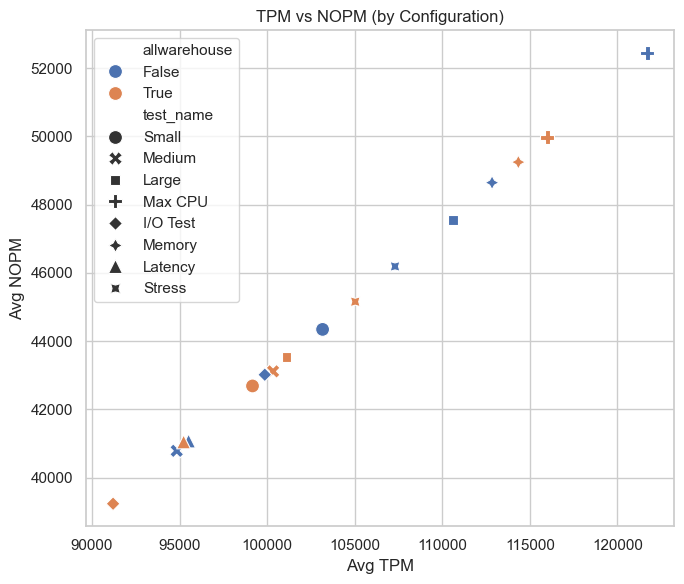

In [22]:
# Correlation coefficient
corr = agg_df[['avg_tpm', 'avg_nopm']].corr().iloc[0, 1]
print(f"Correlation between avg TPM and avg NOPM: {corr:.2f}")

# Scatter plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=agg_df, x='avg_tpm', y='avg_nopm', hue='allwarehouse', style='test_name', s=100)
plt.title("TPM vs NOPM (by Configuration)")
plt.xlabel("Avg TPM")
plt.ylabel("Avg NOPM")
plt.grid(True)
plt.tight_layout()
plt.show()

Most Stable (Lowest std_tpm):


,test_id,test_name,allwarehouse,avg_tpm,std_tpm,min_tpm,max_tpm,avg_nopm,std_nopm,min_nopm,max_nopm,runs
14,8,Stress,False,107304.0,1806.682595,105169,109246,46191.2,742.139273,45246,46919,5
15,8,Stress,True,105031.8,2205.134168,101953,107792,45157.2,998.073494,43672,46301,5
6,4,Max CPU,False,121708.2,3361.480953,117845,125544,52446.6,1458.146872,50713,54138,5
10,6,Memory,False,112844.8,4288.987783,106163,118100,48646.0,1773.267464,45863,50771,5
2,2,Medium,False,94839.8,4996.440853,89365,101887,40787.8,2176.199830,38435,43851,5


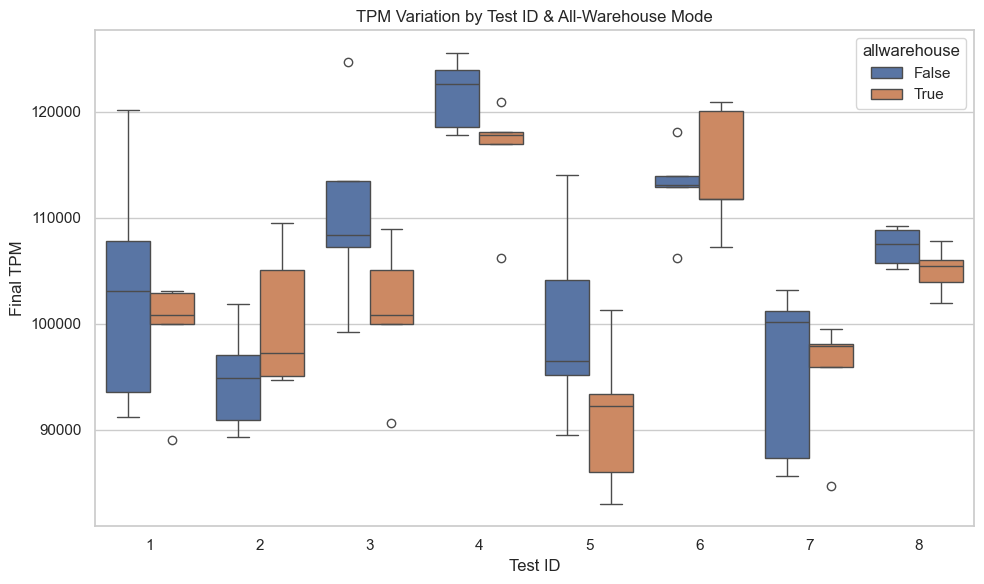

In [21]:
# Top 5 most stable configurations (lowest std)
most_stable = agg_df.sort_values('std_tpm').head(5)
print("Most Stable (Lowest std_tpm):")
display(most_stable)

# Boxplot of TPM variation
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='test_id', y='final_tpm', hue='allwarehouse')
plt.title("TPM Variation by Test ID & All-Warehouse Mode")
plt.xlabel("Test ID")
plt.ylabel("Final TPM")
plt.tight_layout()
plt.show()